In [1]:
import os
import time
import datetime
import json
import requests
import requests.exceptions
import polars as pl
from pathlib import Path
from upsetplot import UpSet, from_memberships
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from cache import load_cache, save_cache

## Create output directory

In [2]:
#output directory
direction = "up"
species = "rice"
now = datetime.datetime.now()
result = Path(f'../result_{direction}_{now.strftime("%y%m")}_{species}')
result.mkdir(parents=True, exist_ok=True)

In [3]:
uniprot_id = pl.read_csv("../Data/Data_uniprot/HN5_rice_down_idmapping_complete.tsv", separator="\t").sort("From").with_columns(pl.col("AlphaFoldDB").str.replace(";", ""))

#uniprot id
# Remove all "null" columns https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.drop_nulls.html
uniprot_id = uniprot_id[[s.name for s in uniprot_id if not (s.null_count() == uniprot_id.height)]]

# if any ortholog database exists, fill with "Ortholog DB" in "Ortholog DB" column
uniprot_id = uniprot_id.with_columns(
    (
        pl.col("OrthoDB").is_not_null() |
        pl.col("OMA").is_not_null() |
        pl.col("eggNOG").is_not_null() |
        pl.col("InParanoid").is_not_null() |
        pl.col("HOGENOM").is_not_null()
    ).map_elements(lambda x: "Ortholog DB" if x else None).alias("Ortholog DB")
)

#Set Review column to null where value is "unreviewed"
uniprot_id = uniprot_id.with_columns(
    pl.when(pl.col("Reviewed") == "unreviewed")
    .then(None)
    .otherwise(pl.col("Reviewed"))
    .alias("Reviewed")
)

display(uniprot_id)

From,Entry,Gene Names (ordered locus),EnsemblPlants,Gramene,Protein names,Proteomes,Reviewed,Length,Annotation,AlphaFoldDB,STRING,Protein families,Sequence similarities,Domain [CC],Domain [FT],InterPro,Pfam,PANTHER,NCBIfam,HOGENOM,OMA,InParanoid,OrthoDB,eggNOG,PlantReactome,EC number,Active site,Rhea ID,Binding site,Function [CC],Site,Catalytic activity,Kinetics,Cofactor,Pathway,DNA binding,pH dependence,Subunit structure,Topological domain,Subcellular location [CC],Transmembrane,PubMed ID,DOI ID,Date of creation,Coiled coil,Motif,Compositional bias,Region,Ortholog DB
str,str,str,str,str,str,str,str,i64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""Os01g0105300""","""A0A0P0UWX1""","""Os01g0105300""","""Os01t0105300-0…","""Os01t0105300-0…","""Os01g0105300 p…","""UP000059680: C…",null,29,1.0,"""A0A0P0UWX1""",null,null,null,null,null,null,null,null,null,null,null,"""A0A0P0UWX1;""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""16100779; 2428…","""10.1038/nature…","""2016-01-20""",null,null,null,null,"""Ortholog DB"""
"""Os01g0136300""","""A0A8J8YJH9""","""Os01g0136300""","""Os01t0136300-0…","""Os01t0136300-0…","""Os01g0136300 p…","""UP000000763: C…",null,156,1.0,null,null,null,null,null,null,null,null,"""PTHR34542:SF2;…",null,"""CLU_1858160_0_…","""HRRFVFG;""",null,null,"""ENOG502R73M;""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""12447438; 1610…","""10.1038/nature…","""2022-05-25""",null,null,null,null,"""Ortholog DB"""
"""Os01g0136300""","""Q5ZC68""","""Os01g0136300""","""Os01t0136300-0…","""Os01t0136300-0…","""Os01g0136300 p…","""UP000059680: C…",null,156,1.0,"""Q5ZC68""",null,null,null,null,null,null,null,"""PTHR34542:SF2;…",null,"""CLU_1858160_0_…","""HRRFVFG;""",null,null,"""ENOG502R73M;""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""16100779; 2329…","""10.1038/nature…","""2004-11-23""",null,null,null,null,"""Ortholog DB"""
"""Os01g0137950""","""A0A0P0UXR3""","""Os01g0137950""","""Os01t0137950-0…","""Os01t0137950-0…","""Os01g0137950 p…","""UP000059680: C…",null,204,1.0,"""A0A0P0UXR3""","""39947.A0A0P0UX…",null,null,null,"""DOMAIN 1..166;…","""IPR011009;IPR0…","""PF00069;""","""PTHR27009:SF97…",null,null,"""ICRREES;""","""A0A0P0UXR3;""",null,"""KOG1187;""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""16100779; 2428…","""10.1038/nature…","""2016-01-20""",null,null,null,null,"""Ortholog DB"""
"""Os01g0179600""","""B7FAP2""","""Os01g0179600""","""Os01t0179600-0…","""Os01t0179600-0…","""Glycosyltransf…","""UP000059680: C…",null,487,1.0,"""B7FAP2""","""39947.B7FAP2;""","""UDP-glycosyltr…","""SIMILARITY: Be…",null,null,"""IPR002213;IPR0…","""PF00201;""","""PTHR11926;PTHR…",null,"""CLU_001724_0_1…","""AYFHYFR;""",null,"""464385at2759;""","""KOG1192;""","""R-OSA-1119482;…","""2.4.1.-""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""16100779; 2329…","""10.1038/nature…","""2009-02-10""",null,null,null,null,"""Ortholog DB"""
"""Os01g0179600""","""Q0JQ63""","""Os01g0179600""","""Os01t0179600-0…","""Os01t0179600-0…","""Glycosyltransf…","""UP000000763: C…",null,487,1.0,"""Q0JQ63""",null,"""UDP-glycosyltr…","""SIMILARITY: Be…",null,null,"""IPR002213;IPR0…","""PF00201;""","""PTHR11926;PTHR…",null,null,"""AYFHYFR;""",null,"""464385at2759;""",null,null,"""2.4.1.-""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""16100779; 1808…","""10.1038/nature…","""2020-02-26""",null,null,null,null,"""Ortholog DB"""
"""Os01g0192900""","""A0A0P0UZP7""","""Os01g0192900 L…",null,null,"""1-aminocyclopr…","""UP000000763: C…","""reviewed""",533,3.0,"""A0A0P0UZP7""","""39947.A0A0P0UZ…","""Class-I pyrido…","""SIMILARITY: Be…",null,null,"""IPR004839;IPR0…","""PF00155;""","""PTHR43795:SF39…",null,"""CLU_01

In [4]:
# this dataframe is used for upsetplot
uniprot_id_select = uniprot_id.select([
    "From",
    "Entry",
    #"Reviewed",
    "InterPro",
    "Ortholog DB"
])

display(uniprot_id_select)

From,Entry,InterPro,Ortholog DB
str,str,str,str
"""Os01g0105300""","""A0A0P0UWX1""",null,"""Ortholog DB"""
"""Os01g0136300""","""A0A8J8YJH9""",null,"""Ortholog DB"""
"""Os01g0136300""","""Q5ZC68""",null,"""Ortholog DB"""
"""Os01g0137950""","""A0A0P0UXR3""","""IPR011009;IPR0…","""Ortholog DB"""
"""Os01g0179600""","""B7FAP2""","""IPR002213;IPR0…","""Ortholog DB"""
"""Os01g0179600""","""Q0JQ63""","""IPR002213;IPR0…","""Ortholog DB"""
"""Os01g0192900""","""A0A0P0UZP7""","""IPR004839;IPR0…","""Ortholog DB"""
"""Os01g0208400""","""A0A8J8YP02""","""IPR021102;""","""Ortholog DB"""
"""Os01g0208400""","""Q8LRI2""","""IPR021102;""","""Ortholog DB"""


In [5]:
def select_row_with_values(df):
    #reviewed_not_null = df.filter(pl.col("Reviewed").is_not_null())
    #if not reviewed_not_null.is_empty():
    #    df = reviewed_not_null
    
    ortholog_db_not_null = df.filter(pl.col("Ortholog DB").is_not_null())
    if not ortholog_db_not_null.is_empty():
        df = ortholog_db_not_null
    
    return df.head(1)


# retrieve unique value from uniprot_id_select dataframe
unique_from_values = uniprot_id_select.select("From").unique().to_series()

# apply select_row_with_values function to unique gene ID
selected_rows = []
for from_value in unique_from_values:
    group_df = uniprot_id_select.filter(pl.col("From") == from_value)
    selected_row = select_row_with_values(group_df)
    selected_rows.append(selected_row)

# join the dataframe
uniprot_id_select_filtered = pl.concat(selected_rows).sort("From").drop("Entry")

display(uniprot_id_select_filtered)

From,InterPro,Ortholog DB
str,str,str
"""Os01g0105300""",null,"""Ortholog DB"""
"""Os01g0136300""",null,"""Ortholog DB"""
"""Os01g0137950""","""IPR011009;IPR0…","""Ortholog DB"""
"""Os01g0179600""","""IPR002213;IPR0…","""Ortholog DB"""
"""Os01g0192900""","""IPR004839;IPR0…","""Ortholog DB"""
"""Os01g0208400""","""IPR021102;""","""Ortholog DB"""
"""Os01g0216000""","""IPR001087;IPR0…","""Ortholog DB"""
"""Os01g0220700""","""IPR047664;IPR0…","""Ortholog DB"""
"""Os01g0232000""","""IPR023271;IPR0…","""Ortholog DB"""


## Upsetplot visualization (1)

/usr/local/lib/python3.10/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/usr/local/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/

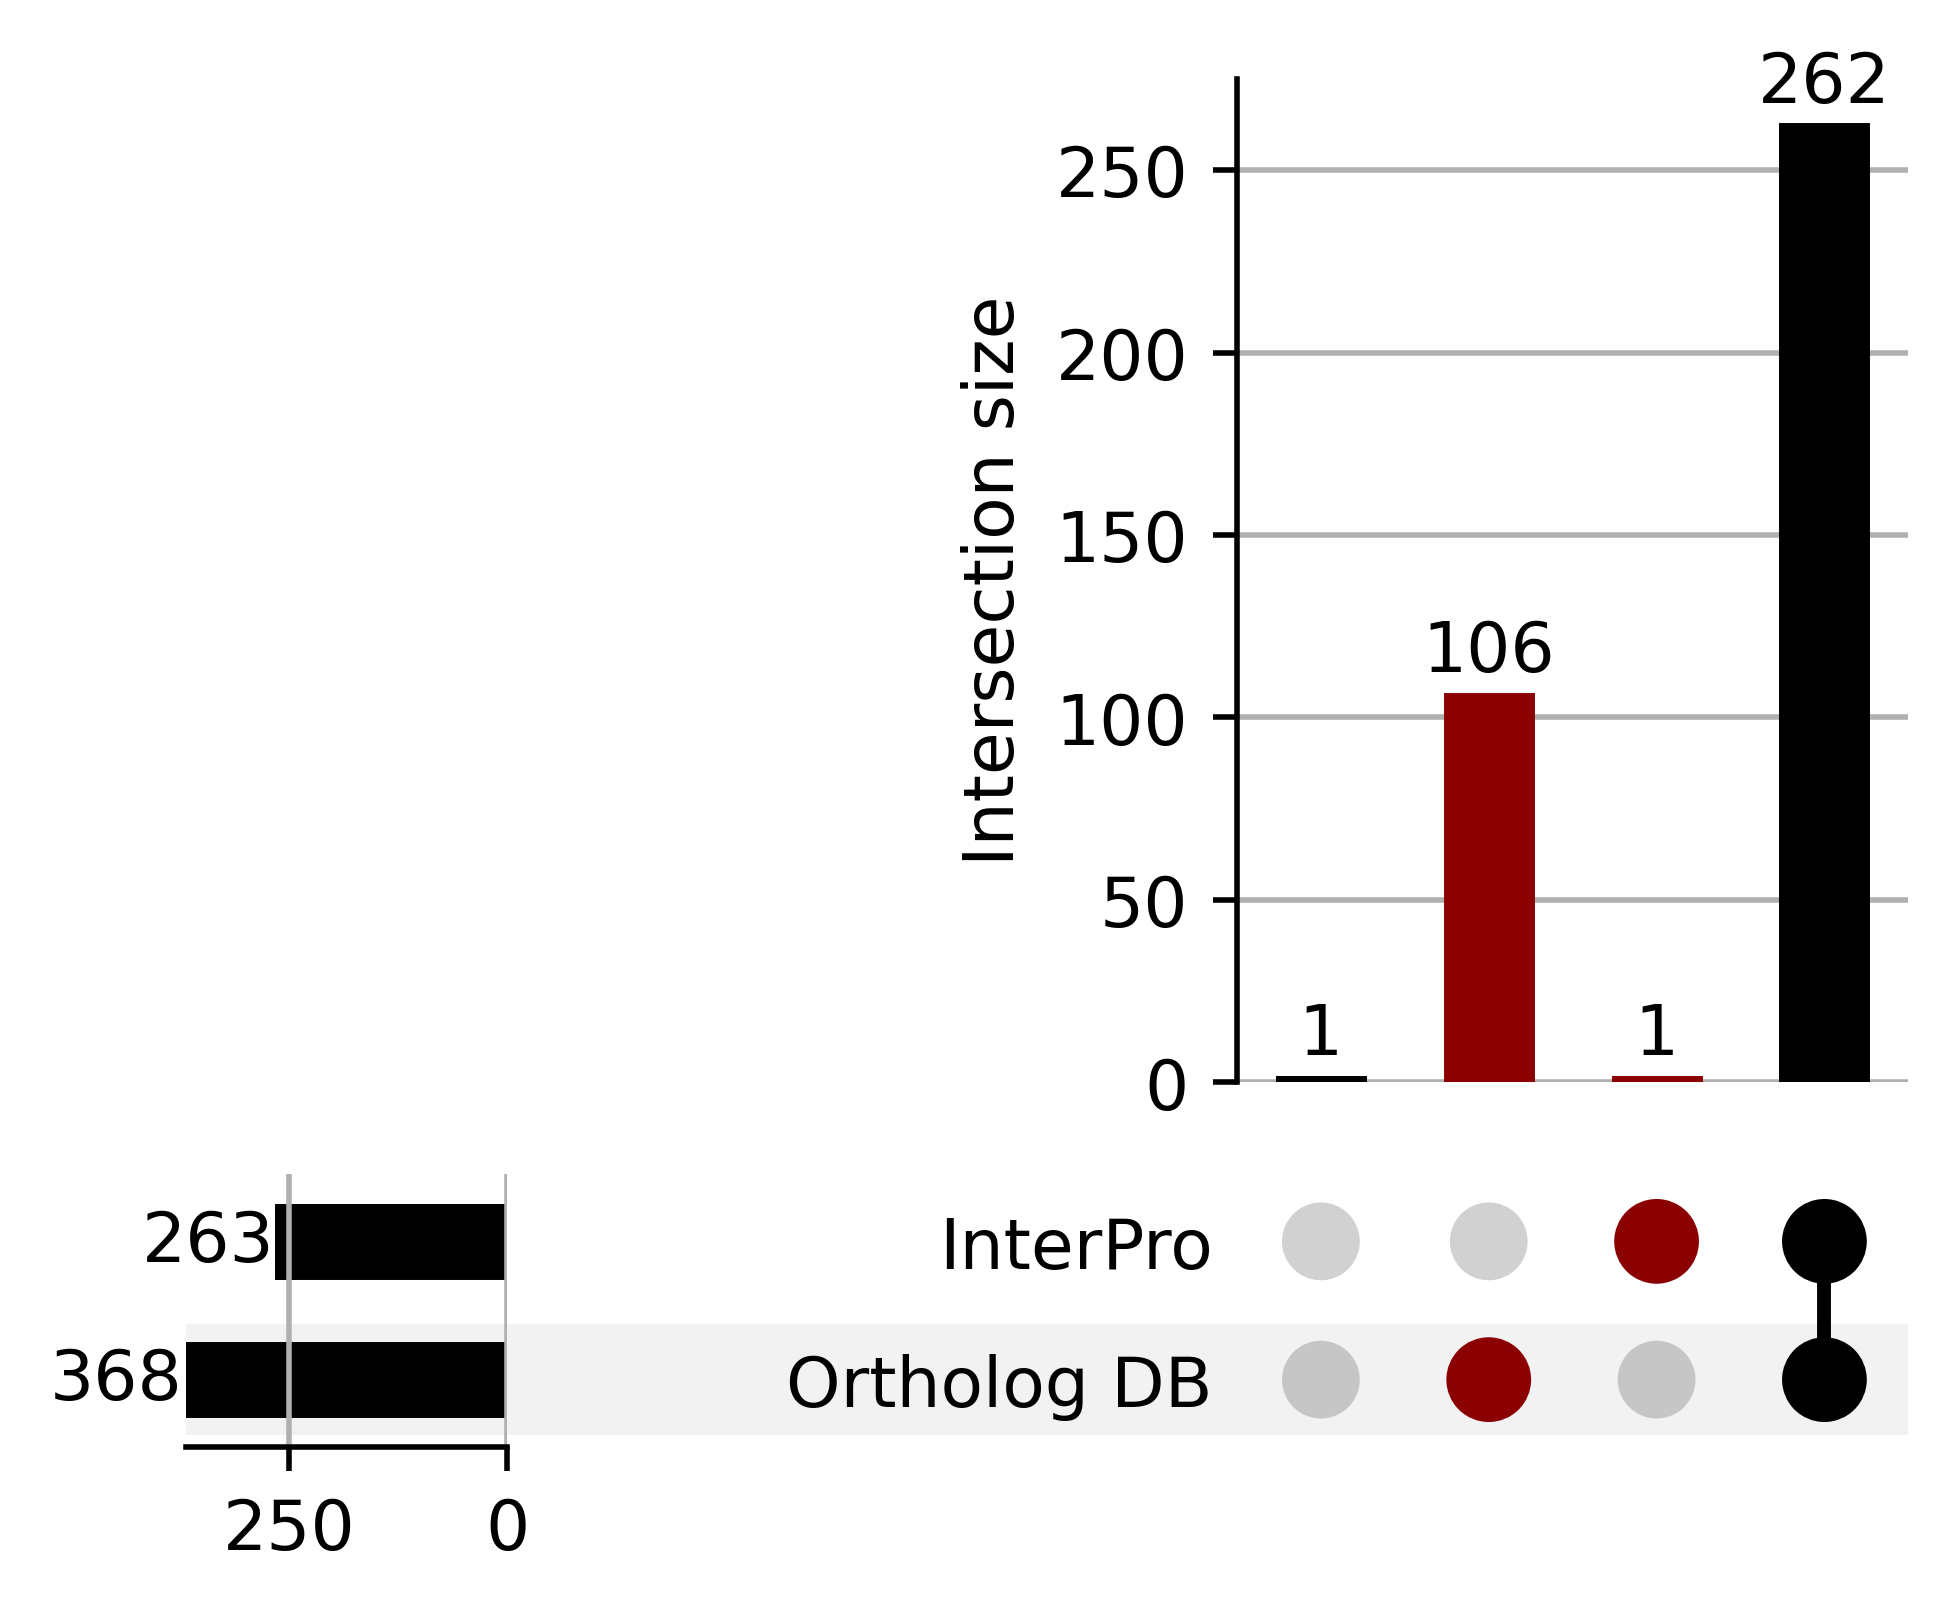

In [6]:
uniprot_data_pd = uniprot_id_select_filtered.to_pandas()

# convert to dict for upsetplot
membership_dict = {}
for index, row in uniprot_data_pd.iterrows():
    membership_list = []
    for col in uniprot_data_pd.columns[1:]:
        if row[col] is not None:
            membership_list.append(col)
    membership_dict[row["From"]] = membership_list

upset_data = from_memberships(membership_dict.values())

upset_plot = UpSet(upset_data, 
                   orientation='horizontal',
                   show_counts="{:d}",
                   subset_size='count', 
                   include_empty_subsets = False)

upset_plot.style_subsets(present="Ortholog DB", 
                         absent="InterPro",
                         facecolor="darkred"
                         )

upset_plot.style_subsets(present="InterPro",
                         absent="Ortholog DB",
                         facecolor="darkred")

fig = plt.figure(figsize=(14, 8), dpi=500)
upset_plot.plot(fig=fig)
plt.show()

## Get sequence similarity informartion from ensembl pan-homology

In [7]:
def get_pan_homology(dataframe, target_taxon: int, json_file: str):
    cache = load_cache(json_file)
    search_result = Path(f'{result}/pan_homology_{target_taxon}')
    search_result.mkdir(parents=True, exist_ok=True)

    def get_id(row):
        gene_id = row[0]
        if gene_id in cache:
            return cache[gene_id]
        
        request_url = f"https://rest.ensembl.org/homology/id/oryza_sativa/{gene_id}?compara=pan_homology&content-type=application/json;target_taxon={target_taxon}"

        try:
            response = requests.get(request_url, headers={"Accept": "application/json"}, timeout=30)
            response.raise_for_status()

            if response.status_code == 200:
                data = json.loads(response.text)
                file_name = f'{search_result}/pan_homology_{gene_id}.json'
                
                if data["data"] and any("homologies" in d for d in data["data"]): #
                    human_gene_ids = []
                    for entry in data["data"]:
                        for homology in entry["homologies"]:
                            if homology["target"]["taxon_id"] == target_taxon:
                                human_gene_ids.append(homology["target"]["id"])
                            elif homology["source"]["taxon_id"] == target_taxon:
                                human_gene_ids.append(homology["source"]["id"])
                    human_gene_ids_str = ",".join(human_gene_ids)
                    cache[gene_id] = human_gene_ids_str
                    with open(file_name, "w") as f:
                        json.dump(data, f, indent=4)
                    save_cache(cache, json_file)
                    return human_gene_ids_str if human_gene_ids_str else None
                else:
                    cache[gene_id] = None
                    save_cache(cache, json_file)
                    return None
            else:
                print(f"Failed to fetch data for {gene_id}")
                return None
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
            return None
        finally:
            time.sleep(5)
    
    pan_homology = dataframe.map_rows(get_id, return_dtype = pl.String)
    dataframe = dataframe.with_columns(
        pl.Series(pan_homology).alias(
            f"pan_homology_{target_taxon}"
            )
        )
    return dataframe

In [8]:
pan_homology_human = get_pan_homology(uniprot_id_select_filtered, 9606, "cache_pan_homology_human_down.json")

pan_homology_human = pan_homology_human.with_columns(
    pl.when(pl.col("pan_homology_9606") == "")
    .then(None)
    .otherwise(pl.col("pan_homology_9606"))
    .alias("pan-homology human")
).drop("pan_homology_9606")

display(pan_homology_human)

From,InterPro,Ortholog DB,pan-homology human
str,str,str,str
"""Os01g0105300""",null,"""Ortholog DB""",null
"""Os01g0136300""",null,"""Ortholog DB""",null
"""Os01g0137950""","""IPR011009;IPR0…","""Ortholog DB""",null
"""Os01g0179600""","""IPR002213;IPR0…","""Ortholog DB""","""ENSG0000017460…"
"""Os01g0192900""","""IPR004839;IPR0…","""Ortholog DB""","""ENSG0000011045…"
"""Os01g0208400""","""IPR021102;""","""Ortholog DB""",null
"""Os01g0216000""","""IPR001087;IPR0…","""Ortholog DB""","""ENSG0000016586…"
"""Os01g0220700""","""IPR047664;IPR0…","""Ortholog DB""",null
"""Os01g0232000""","""IPR023271;IPR0…","""Ortholog DB""","""ENSG0000016526…"


In [9]:
pan_homology_mouse = get_pan_homology(pan_homology_human, 10090, "cache_pan_homology_mouse_down.json")

pan_homology_mouse = pan_homology_mouse.with_columns(
    pl.when(pl.col("pan_homology_10090") == "")
    .then(None)
    .otherwise(pl.col("pan_homology_10090"))
    .alias("pan-homology mouse")
).drop("pan_homology_10090")

display(pan_homology_mouse)

From,InterPro,Ortholog DB,pan-homology human,pan-homology mouse
str,str,str,str,str
"""Os01g0105300""",null,"""Ortholog DB""",null,null
"""Os01g0136300""",null,"""Ortholog DB""",null,null
"""Os01g0137950""","""IPR011009;IPR0…","""Ortholog DB""",null,null
"""Os01g0179600""","""IPR002213;IPR0…","""Ortholog DB""","""ENSG0000017460…","""ENSMUSG0000003…"
"""Os01g0192900""","""IPR004839;IPR0…","""Ortholog DB""","""ENSG0000011045…","""ENSMUSG0000004…"
"""Os01g0208400""","""IPR021102;""","""Ortholog DB""",null,null
"""Os01g0216000""","""IPR001087;IPR0…","""Ortholog DB""","""ENSG0000016586…","""ENSMUSG0000004…"
"""Os01g0220700""","""IPR047664;IPR0…","""Ortholog DB""",null,null
"""Os01g0232000""","""IPR023271;IPR0…","""Ortholog DB""","""ENSG0000016526…","""ENSMUSG0000002…"


/usr/local/lib/python3.10/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/usr/local/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/

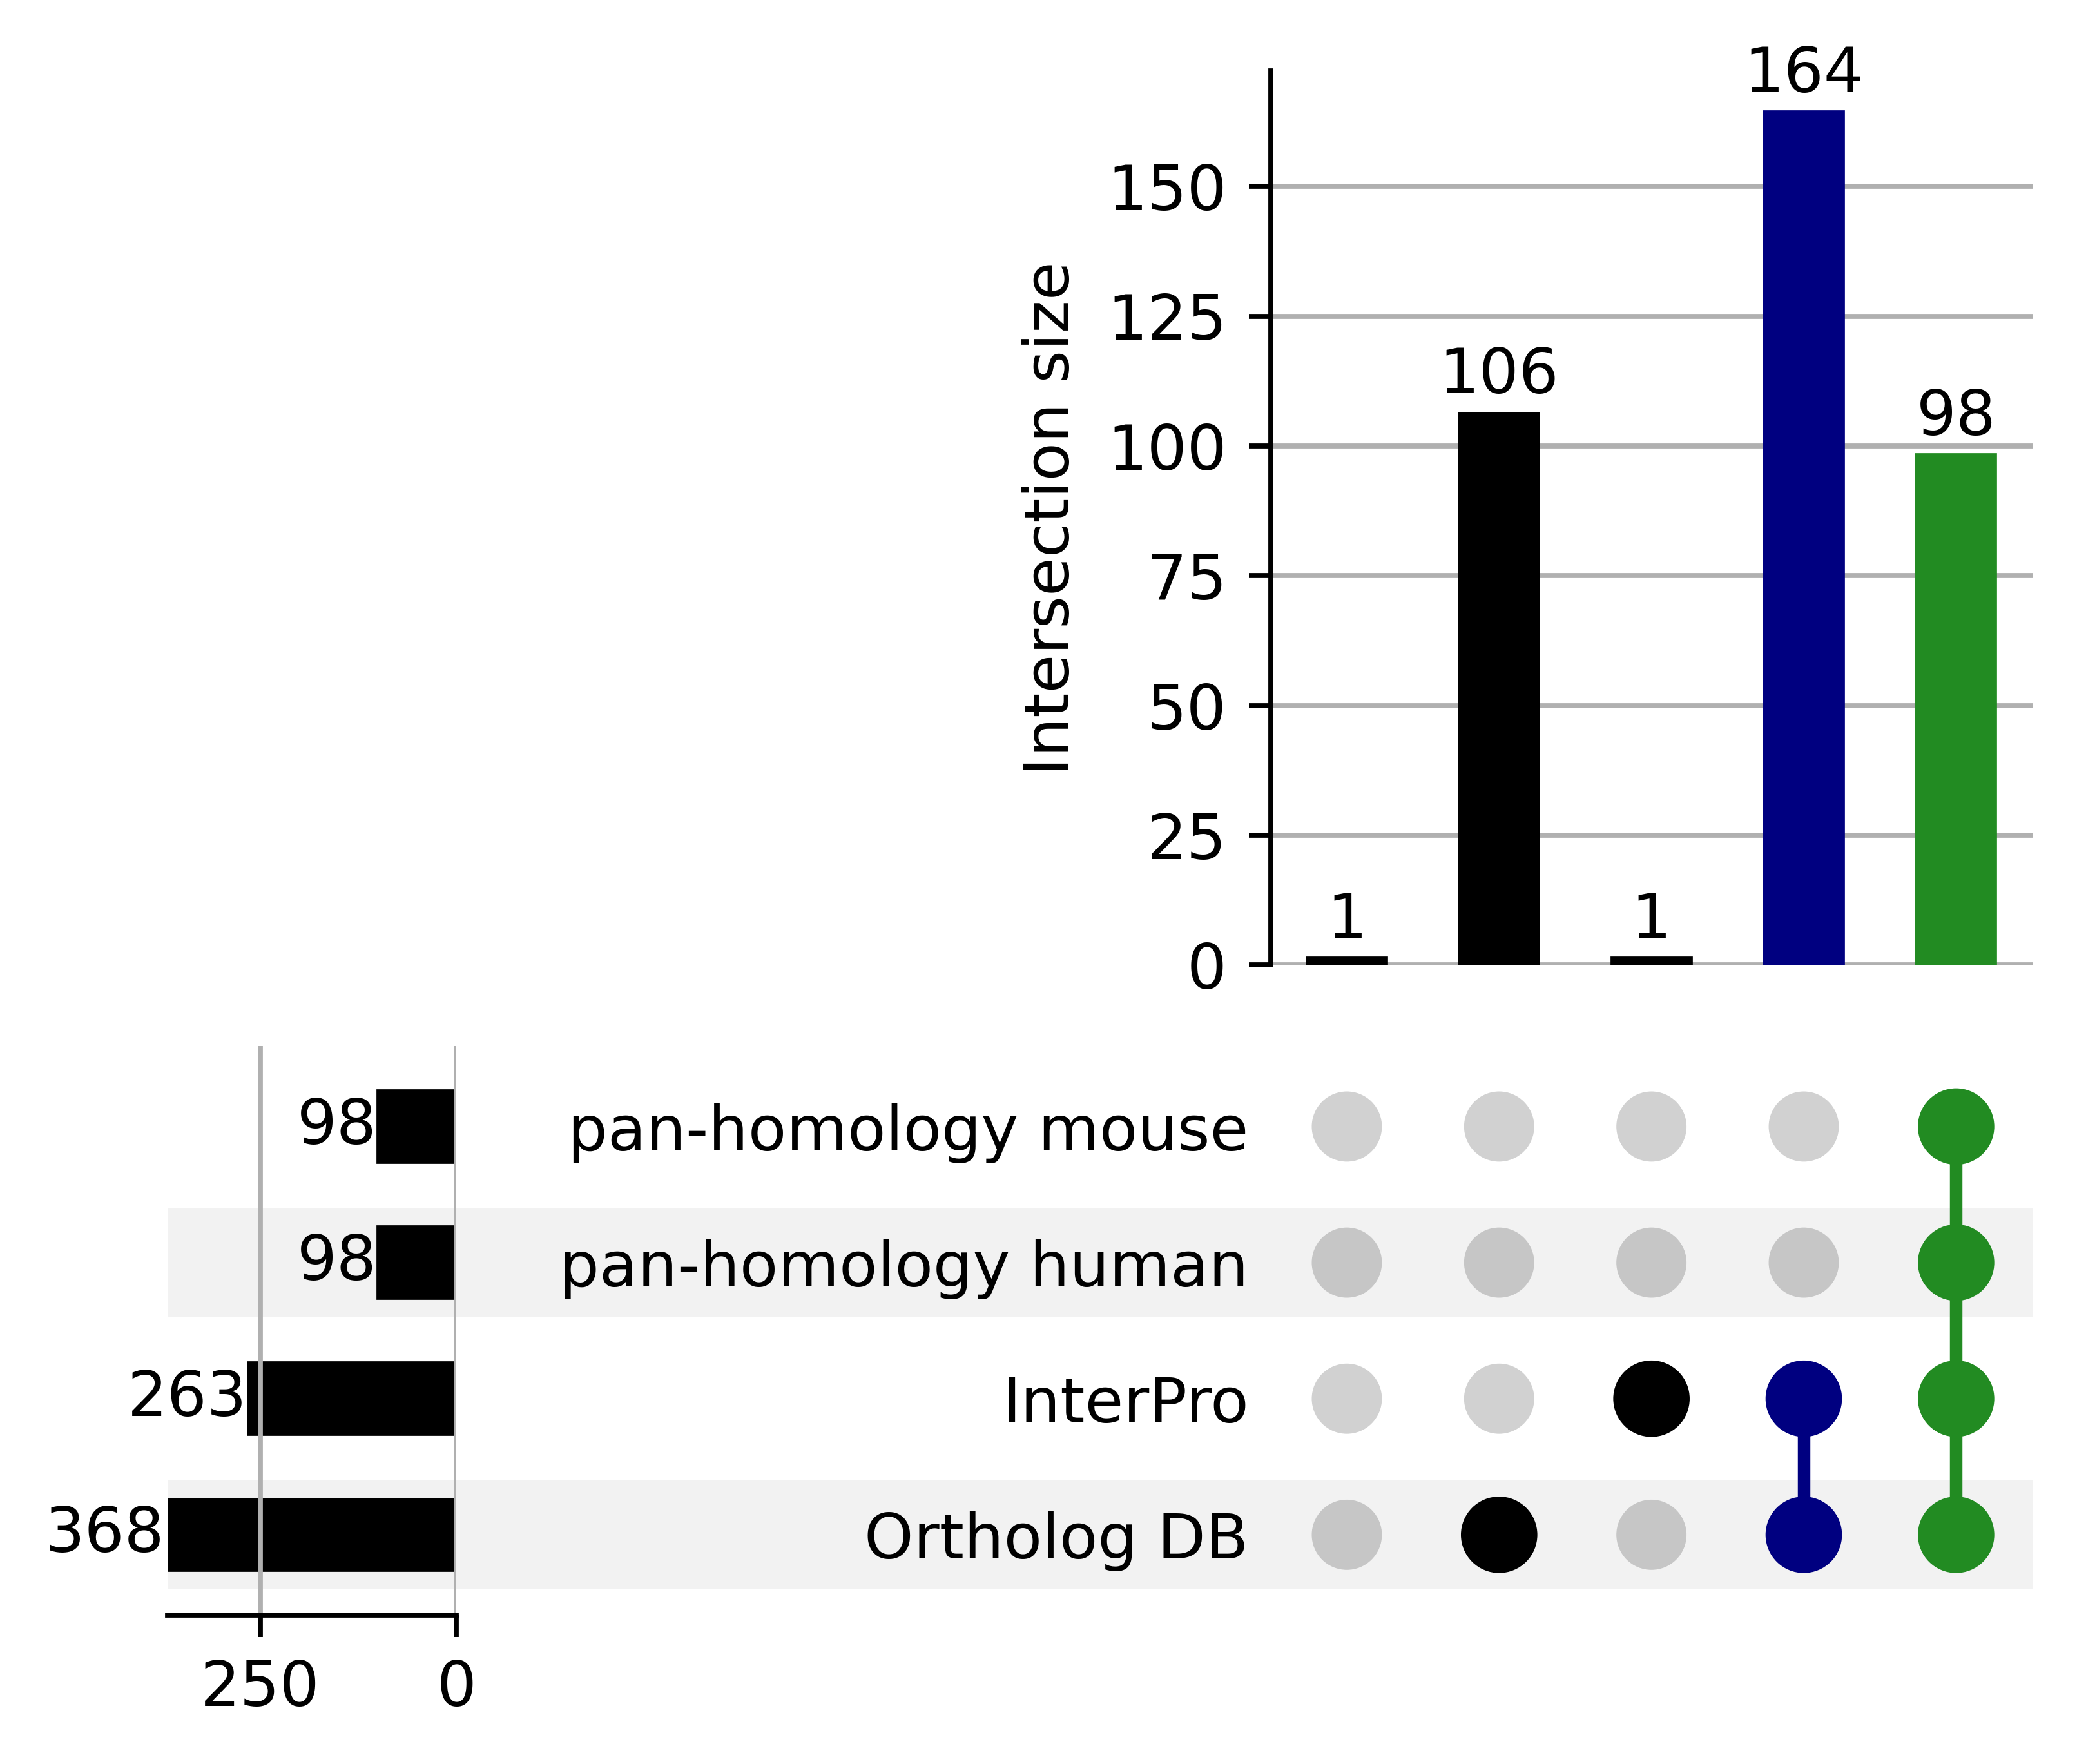

In [11]:
pan_homology_mouse_pd = pan_homology_mouse.to_pandas()

# convert to dict for upsetplot
membership_dict = {}
for index, row in pan_homology_mouse_pd.iterrows():
    membership_list = []
    for col in pan_homology_mouse_pd.columns[1:]:
        if row[col] is not None:
            membership_list.append(col)
    membership_dict[row["From"]] = membership_list

upset_data = from_memberships(membership_dict.values())

upset_plot_3 = UpSet(upset_data, 
                   orientation='horizontal',
                   show_counts="{:d}",
                   subset_size='count', 
                   include_empty_subsets = False)

# Highlighting selected subsets
# 1. pan-homology
upset_plot_3.style_subsets(
    present=["pan-homology human", "pan-homology mouse"],
    facecolor="forestgreen"
)

# 2. InterPro and Ortholog DB
upset_plot_3.style_subsets(
    present=["InterPro", "Ortholog DB"],
    absent=["pan-homology human", "pan-homology mouse"],
    facecolor="navy"
)

fig_3 = plt.figure(figsize=(16, 10), dpi=700)
upset_plot_3.plot(fig=fig_3)
plt.show()

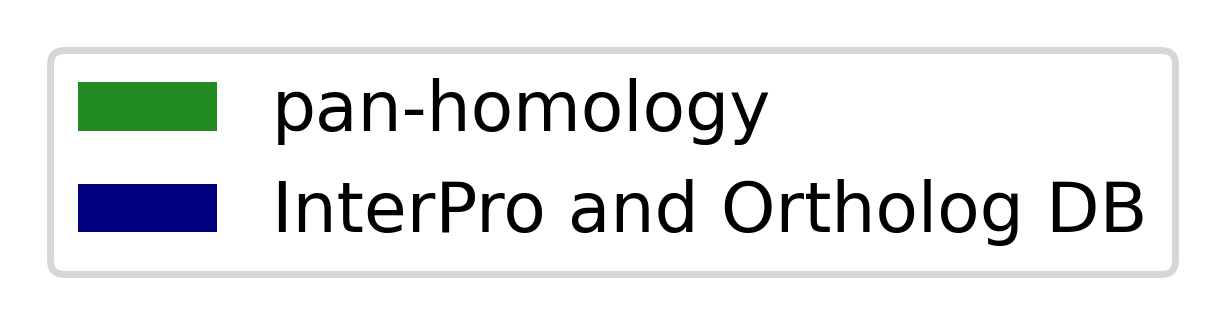

In [12]:
# Create legend independently
legend_elements = [
    Patch(facecolor='forestgreen', label='pan-homology'),
    Patch(facecolor="navy", label="InterPro and Ortholog DB")
]

fig_leg = plt.figure(figsize=(1.5, 0.5), dpi=500)
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(handles=legend_elements, loc='center')
ax_leg.axis('off') 
plt.show()
# fig_leg.savefig('legend.png', bbox_inches='tight')

In [13]:
#save results
pan_homology_mouse.write_csv(
    f"{result}/upsetplot_data_rice_down.tsv", separator="\t"
)

## Classification and download mmCIF files

In [14]:
def get_cif_afurl(dataframe, json_file: str,):
    cache = load_cache(json_file)

    def get_url(row):
        alpha_fold_id = row[3]
        if alpha_fold_id is None or alpha_fold_id == "":
            return None

        if alpha_fold_id in cache:
            return cache[alpha_fold_id]
        
        request_url = f'https://alphafold.ebi.ac.uk/api/prediction/{alpha_fold_id}'

        try:
            response = requests.get(request_url, headers={"Accept": "application/json"}, timeout=30)
            response.raise_for_status()
    
            if response.text:
                data = json.loads(response.text)
                if isinstance(data, list) and len(data) > 0: 
                    print(f"AlphaFold ID {alpha_fold_id} found in AlphaFold")
                    cif_url = data[0].get('cifUrl', None)
                    cache[alpha_fold_id] = cif_url
                    save_cache(cache, json_file)
                    return cif_url
                else:
                    print(f"AlphaFold ID {alpha_fold_id} not found in AlphaFold")
                    return None
            else:
                print(f"Empty response for AlphaFold ID {alpha_fold_id}")
                return None
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
        time.sleep(5)
        return None
    
  
    url = dataframe.map_rows(get_url, return_dtype = pl.String) # specify return_dtype to avoid error (in this case, pl.Boolean)
    dataframe = dataframe.with_columns(
        pl.Series(url).alias(
            "mmCIFfile_AF_URL"
            )
        )
    return dataframe

In [15]:
def download_mmCIF_files(dataframe, target_directory='../rice_up_mmCIFfile'):
    os.makedirs(target_directory, exist_ok=True)
    URL_col = dataframe.select("mmCIFfile_AF_URL").get_columns()[0]

    #retrieve mmCIF file from url
    for url in URL_col:
        if url and url != 'URL not found':
            filename = url.split('/')[-1] # get the last element
            save_path = os.path.join(target_directory, filename)

            if not os.path.exists(save_path): # if file not exists, download it
                response = requests.get(url)
                if response.status_code == 200:
                    with open(save_path, 'wb') as f:
                        f.write(response.content)
                    print(f'File {filename} downloaded successfully')
                    time.sleep(10)
                else:
                    print(f'Failed to download {filename}, HTTP Status Code: {response.status_code}')
            else:
                print(f'File {filename} already exists')
        else:
            print(f'Skipping invalid or missing URL, URL: {url}')
            

def extract_filename(url):
    return url.split("/")[-1]

In [16]:
# 3. pan-homology
pan_homology = pan_homology_mouse.filter(
    (pl.col("pan-homology human").is_not_null()) &
    (pl.col("pan-homology mouse").is_not_null())
).join(
    uniprot_id,
    on="From",
    how="left"
).select(
    [
        "From",
        "Entry",
        "Reviewed",
        "AlphaFoldDB",
        "Protein families",
        "InterPro",
        "Ortholog DB",
        "pan-homology human",
        "pan-homology mouse" 
    ]
).with_columns(
    pl.lit("pan_homology").alias("tag")
)

print(pan_homology.group_by(["From"]).n_unique()) # Check gene count
pan_homology = get_cif_afurl(pan_homology, "cache_af_url.json")
display(pan_homology.head())

shape: (98, 10)
┌─────────────┬───────┬──────────┬─────────────┬───┬─────────────┬─────────────┬─────────────┬─────┐
│ From        ┆ Entry ┆ Reviewed ┆ AlphaFoldDB ┆ … ┆ Ortholog DB ┆ pan-homolog ┆ pan-homolog ┆ tag │
│ ---         ┆ ---   ┆ ---      ┆ ---         ┆   ┆ ---         ┆ y human     ┆ y mouse     ┆ --- │
│ str         ┆ u32   ┆ u32      ┆ u32         ┆   ┆ u32         ┆ ---         ┆ ---         ┆ u32 │
│             ┆       ┆          ┆             ┆   ┆             ┆ u32         ┆ u32         ┆     │
╞═════════════╪═══════╪══════════╪═════════════╪═══╪═════════════╪═════════════╪═════════════╪═════╡
│ Os02g014990 ┆ 1     ┆ 1        ┆ 1           ┆ … ┆ 1           ┆ 1           ┆ 1           ┆ 1   │
│ 0           ┆       ┆          ┆             ┆   ┆             ┆             ┆             ┆     │
│ Os10g052830 ┆ 2     ┆ 1        ┆ 2           ┆ … ┆ 1           ┆ 1           ┆ 1           ┆ 1   │
│ 0           ┆       ┆          ┆             ┆   ┆             ┆         

From,Entry,Reviewed,AlphaFoldDB,Protein families,InterPro,Ortholog DB,pan-homology human,pan-homology mouse,tag,mmCIFfile_AF_URL
str,str,str,str,str,str,str,str,str,str,str
"""Os01g0179600""","""B7FAP2""",null,"""B7FAP2""","""UDP-glycosyltr…","""IPR002213;IPR0…","""Ortholog DB""","""ENSG0000017460…","""ENSMUSG0000003…","""pan_homology""","""https://alphaf…"
"""Os01g0179600""","""Q0JQ63""",null,"""Q0JQ63""","""UDP-glycosyltr…","""IPR002213;IPR0…","""Ortholog DB""","""ENSG0000017460…","""ENSMUSG0000003…","""pan_homology""","""https://alphaf…"
"""Os01g0192900""","""A0A0P0UZP7""","""reviewed""","""A0A0P0UZP7""","""Class-I pyrido…","""IPR004839;IPR0…","""Ortholog DB""","""ENSG0000011045…","""ENSMUSG0000004…","""pan_homology""","""https://alphaf…"
"""Os01g0216000""","""Q0JPL7""",null,null,"""'GDSL' lipolyt…","""IPR001087;IPR0…","""Ortholog DB""","""ENSG0000016586…","""ENSMUSG0000004…","""pan_homology""",null
"""Os01g0216000""","""Q9LHW4""",null,"""Q9LHW4""","""'GDSL' lipolyt…","""IPR001087;IPR0…","""Ortholog DB""","""ENSG0000016586…","""ENSMUSG0000004…","""pan_homology""","""https://alphaf…"


In [17]:
# 5. InterPro and Ortholog DB
interpro_orthologdb = pan_homology_mouse.filter(
    (pl.col("InterPro").is_not_null()) &
    (pl.col("Ortholog DB").is_not_null()) &
    (~pl.col("pan-homology human").is_not_null()) &
    (~pl.col("pan-homology mouse").is_not_null())
).join(
    uniprot_id,
    on="From",
    how="left"
).select(
    [
        "From",
        "Entry",
        "Reviewed",
        "AlphaFoldDB",
        "Protein families",
        "InterPro",
        "Ortholog DB",
        "pan-homology human",
        "pan-homology mouse" 
    ]
).with_columns(
    pl.lit("interpro_orthologdb").alias("tag")
)

print(interpro_orthologdb.group_by(["From"]).n_unique()) # Check gene count

# download mmCIF file
interpro_orthologdb = get_cif_afurl(interpro_orthologdb, "cache_af_url.json")
display(interpro_orthologdb.head())

shape: (164, 10)
┌─────────────┬───────┬──────────┬─────────────┬───┬─────────────┬─────────────┬─────────────┬─────┐
│ From        ┆ Entry ┆ Reviewed ┆ AlphaFoldDB ┆ … ┆ Ortholog DB ┆ pan-homolog ┆ pan-homolog ┆ tag │
│ ---         ┆ ---   ┆ ---      ┆ ---         ┆   ┆ ---         ┆ y human     ┆ y mouse     ┆ --- │
│ str         ┆ u32   ┆ u32      ┆ u32         ┆   ┆ u32         ┆ ---         ┆ ---         ┆ u32 │
│             ┆       ┆          ┆             ┆   ┆             ┆ u32         ┆ u32         ┆     │
╞═════════════╪═══════╪══════════╪═════════════╪═══╪═════════════╪═════════════╪═════════════╪═════╡
│ Os06g069760 ┆ 2     ┆ 1        ┆ 1           ┆ … ┆ 1           ┆ 1           ┆ 1           ┆ 1   │
│ 0           ┆       ┆          ┆             ┆   ┆             ┆             ┆             ┆     │
│ Os01g068945 ┆ 2     ┆ 1        ┆ 2           ┆ … ┆ 1           ┆ 1           ┆ 1           ┆ 1   │
│ 1           ┆       ┆          ┆             ┆   ┆             ┆        

From,Entry,Reviewed,AlphaFoldDB,Protein families,InterPro,Ortholog DB,pan-homology human,pan-homology mouse,tag,mmCIFfile_AF_URL
str,str,str,str,str,str,str,str,str,str,str
"""Os01g0137950""","""A0A0P0UXR3""",null,"""A0A0P0UXR3""",null,"""IPR011009;IPR0…","""Ortholog DB""",null,null,"""interpro_ortho…","""https://alphaf…"
"""Os01g0208400""","""A0A8J8YP02""",null,null,null,"""IPR021102;""","""Ortholog DB""",null,null,"""interpro_ortho…",null
"""Os01g0208400""","""Q8LRI2""",null,"""Q8LRI2""",null,"""IPR021102;""","""Ortholog DB""",null,null,"""interpro_ortho…","""https://alphaf…"
"""Os01g0220700""","""A0A0P0V0L5""",null,"""A0A0P0V0L5""","""SWEET sugar tr…","""IPR047664;IPR0…","""Ortholog DB""",null,null,"""interpro_ortho…","""https://alphaf…"
"""Os01g0248300""","""Q7F7C9""",null,"""Q7F7C9""",null,"""IPR032710;""","""Ortholog DB""",null,null,"""interpro_ortho…","""https://alphaf…"


In [18]:
# 6. Only InterPro
only_interpro = pan_homology_mouse.filter(
    (pl.col("InterPro").is_not_null()) &
    (~pl.col("Ortholog DB").is_not_null()) &
    (~pl.col("pan-homology human").is_not_null()) &
    (~pl.col("pan-homology mouse").is_not_null())
).join(
    uniprot_id,
    on="From",
    how="left"
).select(
    [
        "From",
        "Entry",
        "Reviewed",
        "AlphaFoldDB",
        "Protein families",
        "InterPro",
        "Ortholog DB",
        "pan-homology human",
        "pan-homology mouse" 
    ]
)

# 6. Only ortholog DB
only_orthologdb = pan_homology_mouse.filter(
    (~pl.col("InterPro").is_not_null()) &
    (pl.col("Ortholog DB").is_not_null()) &
    (~pl.col("pan-homology human").is_not_null()) &
    (~pl.col("pan-homology mouse").is_not_null())
).join(
    uniprot_id,
    on="From",
    how="left"
).select(
    [
        "From",
        "Entry",
        "Reviewed",
        "AlphaFoldDB",
        "Protein families",
        "InterPro",
        "Ortholog DB",
        "pan-homology human",
        "pan-homology mouse" 
    ]
)

only_information = pl.concat(
    [only_interpro, only_orthologdb]
).with_columns(
    pl.lit("only_information").alias("tag")
)

print(only_information.group_by(["From"]).n_unique()) # Check gene count
# download mmCIF file
only_information = get_cif_afurl(only_information, "cache_af_url.json")
display(only_information.head())

shape: (107, 10)
┌─────────────┬───────┬──────────┬─────────────┬───┬─────────────┬─────────────┬─────────────┬─────┐
│ From        ┆ Entry ┆ Reviewed ┆ AlphaFoldDB ┆ … ┆ Ortholog DB ┆ pan-homolog ┆ pan-homolog ┆ tag │
│ ---         ┆ ---   ┆ ---      ┆ ---         ┆   ┆ ---         ┆ y human     ┆ y mouse     ┆ --- │
│ str         ┆ u32   ┆ u32      ┆ u32         ┆   ┆ u32         ┆ ---         ┆ ---         ┆ u32 │
│             ┆       ┆          ┆             ┆   ┆             ┆ u32         ┆ u32         ┆     │
╞═════════════╪═══════╪══════════╪═════════════╪═══╪═════════════╪═════════════╪═════════════╪═════╡
│ Os04g030290 ┆ 1     ┆ 1        ┆ 1           ┆ … ┆ 1           ┆ 1           ┆ 1           ┆ 1   │
│ 0           ┆       ┆          ┆             ┆   ┆             ┆             ┆             ┆     │
│ Os02g077940 ┆ 2     ┆ 1        ┆ 2           ┆ … ┆ 1           ┆ 1           ┆ 1           ┆ 1   │
│ 0           ┆       ┆          ┆             ┆   ┆             ┆        

From,Entry,Reviewed,AlphaFoldDB,Protein families,InterPro,Ortholog DB,pan-homology human,pan-homology mouse,tag,mmCIFfile_AF_URL
str,str,str,str,str,str,str,str,str,str,str
"""Os01g0778400""","""A0A0P0V901""",null,"""A0A0P0V901""","""AG-peptide AGP…","""IPR039281;""",null,null,null,"""only_informati…","""https://alphaf…"
"""Os01g0105300""","""A0A0P0UWX1""",null,"""A0A0P0UWX1""",null,null,"""Ortholog DB""",null,null,"""only_informati…","""https://alphaf…"
"""Os01g0136300""","""A0A8J8YJH9""",null,null,null,null,"""Ortholog DB""",null,null,"""only_informati…",null
"""Os01g0136300""","""Q5ZC68""",null,"""Q5ZC68""",null,null,"""Ortholog DB""",null,null,"""only_informati…","""https://alphaf…"
"""Os01g0318400""","""Q0JN80""",null,"""Q0JN80""",null,null,"""Ortholog DB""",null,null,"""only_informati…","""https://alphaf…"


In [20]:
# 4. No hit
no_hit = pan_homology_mouse.filter(
    (~pl.col("InterPro").is_not_null()) &
    (~pl.col("Ortholog DB").is_not_null()) &
    (~pl.col("pan-homology human").is_not_null()) &
    (~pl.col("pan-homology mouse").is_not_null())
).join(
    uniprot_id,
    on="From",
    how="left"
).select(
    [
        "From",
        "Entry",
        "Reviewed",
        "AlphaFoldDB",
        "Protein families",
        "InterPro",
        "Ortholog DB",
        "pan-homology human",
        "pan-homology mouse" 
    ]
).with_columns(
    pl.lit("no_hit").alias("tag")
)

print(no_hit.group_by(["From"]).n_unique()) # Check gene count
# download mmCIF file
no_hit = get_cif_afurl(no_hit, "cache_af_url.json")
display(no_hit.head())

shape: (1, 10)
┌─────────────┬───────┬──────────┬─────────────┬───┬─────────────┬─────────────┬─────────────┬─────┐
│ From        ┆ Entry ┆ Reviewed ┆ AlphaFoldDB ┆ … ┆ Ortholog DB ┆ pan-homolog ┆ pan-homolog ┆ tag │
│ ---         ┆ ---   ┆ ---      ┆ ---         ┆   ┆ ---         ┆ y human     ┆ y mouse     ┆ --- │
│ str         ┆ u32   ┆ u32      ┆ u32         ┆   ┆ u32         ┆ ---         ┆ ---         ┆ u32 │
│             ┆       ┆          ┆             ┆   ┆             ┆ u32         ┆ u32         ┆     │
╞═════════════╪═══════╪══════════╪═════════════╪═══╪═════════════╪═════════════╪═════════════╪═════╡
│ Os11g017090 ┆ 1     ┆ 1        ┆ 1           ┆ … ┆ 1           ┆ 1           ┆ 1           ┆ 1   │
│ 0           ┆       ┆          ┆             ┆   ┆             ┆             ┆             ┆     │
└─────────────┴───────┴──────────┴─────────────┴───┴─────────────┴─────────────┴─────────────┴─────┘


From,Entry,Reviewed,AlphaFoldDB,Protein families,InterPro,Ortholog DB,pan-homology human,pan-homology mouse,tag,mmCIFfile_AF_URL
str,str,str,str,str,str,str,str,str,str,str
"""Os11g0170900""","""A0A0P0XZM0""",null,"""A0A0P0XZM0""",null,null,null,null,null,"""no_hit""","""https://alphaf…"


In [21]:
all_information = pl.concat([
    pan_homology,
    interpro_orthologdb,
    only_information,
    no_hit
]).sort(
    "From"
)
print(all_information.group_by(["From"]).n_unique()) # Check gene count
display(all_information.head())

shape: (370, 11)
┌─────────────┬───────┬──────────┬─────────────┬───┬─────────────┬─────────────┬─────┬─────────────┐
│ From        ┆ Entry ┆ Reviewed ┆ AlphaFoldDB ┆ … ┆ pan-homolog ┆ pan-homolog ┆ tag ┆ mmCIFfile_A │
│ ---         ┆ ---   ┆ ---      ┆ ---         ┆   ┆ y human     ┆ y mouse     ┆ --- ┆ F_URL       │
│ str         ┆ u32   ┆ u32      ┆ u32         ┆   ┆ ---         ┆ ---         ┆ u32 ┆ ---         │
│             ┆       ┆          ┆             ┆   ┆ u32         ┆ u32         ┆     ┆ u32         │
╞═════════════╪═══════╪══════════╪═════════════╪═══╪═════════════╪═════════════╪═════╪═════════════╡
│ Os12g011680 ┆ 1     ┆ 1        ┆ 1           ┆ … ┆ 1           ┆ 1           ┆ 1   ┆ 1           │
│ 0           ┆       ┆          ┆             ┆   ┆             ┆             ┆     ┆             │
│ Os01g059130 ┆ 3     ┆ 1        ┆ 3           ┆ … ┆ 1           ┆ 1           ┆ 1   ┆ 3           │
│ 0           ┆       ┆          ┆             ┆   ┆             ┆        

From,Entry,Reviewed,AlphaFoldDB,Protein families,InterPro,Ortholog DB,pan-homology human,pan-homology mouse,tag,mmCIFfile_AF_URL
str,str,str,str,str,str,str,str,str,str,str
"""Os01g0105300""","""A0A0P0UWX1""",null,"""A0A0P0UWX1""",null,null,"""Ortholog DB""",null,null,"""only_informati…","""https://alphaf…"
"""Os01g0136300""","""A0A8J8YJH9""",null,null,null,null,"""Ortholog DB""",null,null,"""only_informati…",null
"""Os01g0136300""","""Q5ZC68""",null,"""Q5ZC68""",null,null,"""Ortholog DB""",null,null,"""only_informati…","""https://alphaf…"
"""Os01g0137950""","""A0A0P0UXR3""",null,"""A0A0P0UXR3""",null,"""IPR011009;IPR0…","""Ortholog DB""",null,null,"""interpro_ortho…","""https://alphaf…"
"""Os01g0179600""","""B7FAP2""",null,"""B7FAP2""","""UDP-glycosyltr…","""IPR002213;IPR0…","""Ortholog DB""","""ENSG0000017460…","""ENSMUSG0000003…","""pan_homology""","""https://alphaf…"


## Save results


In [22]:
pan_homology.write_csv(f"{result}/pan_homology.tsv", separator="\t")
interpro_orthologdb.write_csv(f"{result}/interpro_orthologdb.tsv", separator="\t")
only_information.write_csv(f"{result}/only_one_information.tsv", separator="\t")
no_hit.write_csv(f"{result}/no_hit.tsv", separator="\t")
all_information.write_csv(f"{result}/all_information.tsv", separator="\t")